In [1]:
%matplotlib inline
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys
#sys.path.append('/mnt/lustre/share/zhanxiaohang/proj/cocoapi/PythonAPI')
sys.path.append('/home/xhzhan/deps/cocoapi/PythonAPI')
import pycocotools.mask as maskUtils
import cv2
import yaml
import numpy as np
import cvbase as cvb
from PIL import Image
from skimage import measure


import torch.nn as nn

sys.path.append('..')
import models
import utils
import inference as infer
import pdb
from datasets import EraserSetter, KINSLVISDataset
data_root = '/home/xhzhan/data'
# data_root = '../data'

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [10]:
class ArgObj(object):
    def __init__(self):
        pass

class Tester(object):
    
    def __init__(self, config_file, load_iter):
        args = ArgObj()
        with open(config_file, 'r') as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        
        if not hasattr(args, 'exp_path'):
            args.exp_path = os.path.dirname(config_file)
        
        self.model = models.__dict__[args.model['arch']](args.model, dist_model=False)
        self.model.load_state("{}/checkpoints".format(args.exp_path), load_iter)
        
        self.model.switch_to('eval')
        self.use_rgb = args.model['use_rgb']
        
        self.args = args

def make_json_dict(imgs, anns, dataset):
    imgs_dict = {}
    anns_dict = {}
    for ann in anns:
        image_id = ann["image_id"]
        if not image_id in anns_dict:
            anns_dict[image_id] = []
            anns_dict[image_id].append(ann)
        else:
            anns_dict[image_id].append(ann)

    for img in imgs:
        image_id = img['id']
        if dataset == 'LVIS':
            imgs_dict[image_id] = img['file_name']
        else:
            imgs_dict[image_id] = 'COCO_val2014_' + img['file_name']

    return imgs_dict, anns_dict

def show(inputs, scale=1.0):
    num = len(inputs)
    cols = num
    plt.figure(figsize=(12*scale, 12*scale/cols))
    for i in range(num):
        plt.subplot(1, cols, i + 1)
        plt.imshow(inputs[i])
        plt.axis('off')
    plt.show()
    
def combine(inst, eraser):
    inst = inst.copy().astype(np.float32)
    inst[eraser == 1] = 0.5
    return inst

def colormap(mask):
    show = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for c in range(3):
        show[:,:,c][mask == 1] = 255
        show[:,:,c][mask == 0.5] = 128
    return show
    
def draw_graph(matrix, ind=None, pos=None):
    edges = np.where(matrix == 1)
    if ind is not None:
        from_idx = []
        to_idx = []
        for i in range(len(edges[0])):
            if edges[0][i] in ind and edges[1][i] in ind:
                from_idx.append(edges[0][i])
                to_idx.append(edges[1][i])
    else:
        from_idx = edges[0].tolist()
        to_idx = edges[1].tolist()
        
    from_node = [str(i+1) for i in from_idx]
    to_node = [str(i+1) for i in to_idx]

    G = nx.DiGraph()
    G.add_edges_from(list(zip(from_node, to_node)))
    if pos is None:
#         pos = nx.kamada_kawai_layout(G)
        pos = nx.spring_layout(G,k=0.5,iterations=20)
#         pos = nx.planar_layout(G)
    nx.draw_networkx_nodes(G, pos)
    nx.draw_networkx_labels(G, pos, font_color='w')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, width=2)
    return pos

def expand_bbox(bboxes, enlarge_ratio):
    new_bboxes = []
    for bbox in bboxes:
        centerx = bbox[0] + bbox[2] / 2.
        centery = bbox[1] + bbox[3] / 2.
        size = max([np.sqrt(bbox[2] * bbox[3] * enlarge_ratio), bbox[2] * 1.1, bbox[3] * 1.1])
        new_bbox = [int(centerx - size / 2.), int(centery - size / 2.), int(size), int(size)]
        new_bboxes.append(new_bbox)
    return np.array(new_bboxes)

In [4]:
phase = 'val'
dataset = 'LVIS'
if phase == 'train':
    src_img_path = "{}/{}/train2017".format(data_root, dataset)
else:
    src_img_path = "{}/{}/val2017".format(data_root, dataset)
if dataset == 'LVIS':
    annot_fn = "{}/LVIS/lvis_v0.5_{}.json".format(data_root, phase)
else:
    annot_fn = '{}/mscoco17/instances_{}2017.json'.format(data_root, phase)
    
reader = KINSLVISDataset(dataset, annot_fn)
annotation = cvb.load(annot_fn)
imgs_info = annotation['images']
anns_info = annotation["annotations"]

imgs_dict, anns_dict = make_json_dict(imgs_info, anns_info, dataset)
count = 0
img_ids = list(anns_dict.keys())

cat_name = [a['name'] for a in annotation['categories']]
category_dict = dict(zip(
    [a['id'] for a in annotation['categories']], cat_name))

cat_dict = dict(zip(cat_name, [[] for _ in cat_name]))
for imgid in anns_dict.keys():
    cats = [ann['category_id'] for ann in anns_dict[imgid]]
    cats = np.unique(np.array(cats))
    for c in cats:
        cat_dict[category_dict[c]].append(imgid)

In [374]:
cat_name

['acorn',
 'aerosol_can',
 'air_conditioner',
 'airplane',
 'alarm_clock',
 'alcohol',
 'alligator',
 'almond',
 'ambulance',
 'amplifier',
 'anklet',
 'antenna',
 'apple',
 'apple_juice',
 'applesauce',
 'apricot',
 'apron',
 'aquarium',
 'armband',
 'armchair',
 'armoire',
 'armor',
 'artichoke',
 'trash_can',
 'ashtray',
 'asparagus',
 'atomizer',
 'avocado',
 'award',
 'awning',
 'ax',
 'baby_buggy',
 'basketball_backboard',
 'backpack',
 'handbag',
 'suitcase',
 'bagel',
 'bagpipe',
 'baguet',
 'bait',
 'ball',
 'ballet_skirt',
 'balloon',
 'bamboo',
 'banana',
 'Band_Aid',
 'bandage',
 'bandanna',
 'banjo',
 'banner',
 'barbell',
 'barge',
 'barrel',
 'barrette',
 'barrow',
 'baseball_base',
 'baseball',
 'baseball_bat',
 'baseball_cap',
 'baseball_glove',
 'basket',
 'basketball_hoop',
 'basketball',
 'bass_horn',
 'bat_(animal)',
 'bath_mat',
 'bath_towel',
 'bathrobe',
 'bathtub',
 'batter_(food)',
 'battery',
 'beachball',
 'bead',
 'beaker',
 'bean_curd',
 'beanbag',
 'beani

In [5]:
exp = '../experiments/LVIS/partial_unet2_in5_front0.8'

config_file = exp + '/config.yaml'
load_iter = 160000

tester = Tester(config_file, load_iter)

/home/xhzhan/anaconda3/envs/pytorch041/lib/python3.7/site-packages/ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.


=> loading checkpoint '../experiments/LVIS/partial_unet2_in5_front0.8/checkpoints/ckpt_iter_160000.pth.tar'


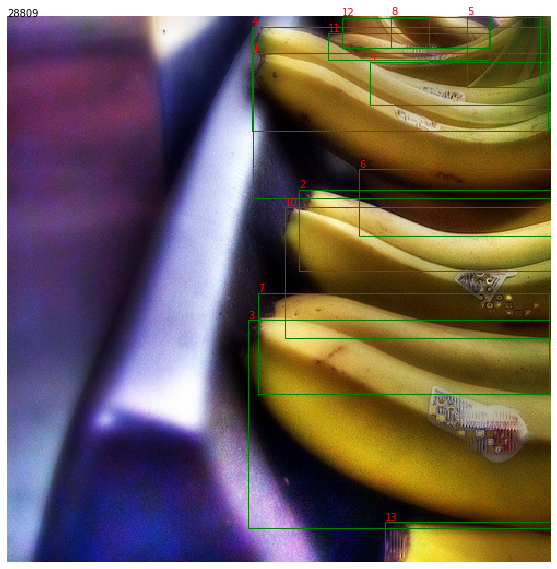

In [20]:
cat_sel = 'banana'
img_id = np.random.choice(cat_dict[cat_sel])
#img_id = list(anns_dict.keys())[2]
# img_id = 4009
# img_id = 2658
# img_id = 2692
# img_id = 6091
# img_id = 6189
# img_id = 1401
# img_id = 6089
# img_id = 1579
# img_id = 1893
# img_id = 5384
# img_id = 5539
# img_id = 196
# img_id = 139260
# img_id = 161820
# img_id = 35279
# img_id = 166166
img_idx = img_ids.index(img_id)
img_name = imgs_dict[img_id]

img_path = os.path.join(src_img_path, img_name)
img = Image.open(img_path)

height, width = img.height, img.width
anns = anns_dict[img_id]

plt.figure(figsize=(10, 10./width*height))
plt.imshow(img)
plt.axis('off')
plt.text(0, 0, str(img_id))
ax = plt.gca()

for i, ann in enumerate(anns):
    bbox = ann['bbox']
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i+1), color='r')
    
plt.show()

modal, category, bboxes, _, _ = reader.get_image_instances(img_idx)
bboxes = expand_bbox(bboxes, enlarge_ratio=3.)
order_matrix, ind, inmodal_patches, eraser_patches, amodal_patches = infer.infer_order2(
    tester.model, np.array(img), modal, category, bboxes,
    use_rgb=tester.use_rgb, th=0.1, dilate_kernel=0,
    input_size=256, min_input_size=16, interp='nearest', debug_info=True)

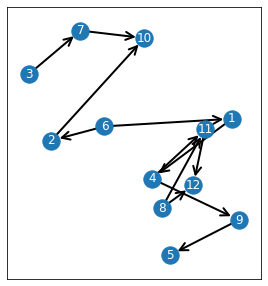

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(121)
#ind = np.array([9,4,18,13,6,3,11,20,22])-1
ind = None
pos = draw_graph(order_matrix, ind)
#plt.subplot(122)
#draw_graph(gt_order_matrix, pos)
plt.show()

In [406]:
interp = 'linear'
inmodal_patches, eraser_patches, amodal_patches_pred = infer.infer_amodal(
    tester.model, image, inmodal, category, bboxes, order_matrix,
    use_rgb=tester.use_rgb, th=0.3, dilate_kernel=5,
    input_size=256, min_input_size=16, interp=interp, debug_info=True)
amodal_pred = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp=interp)

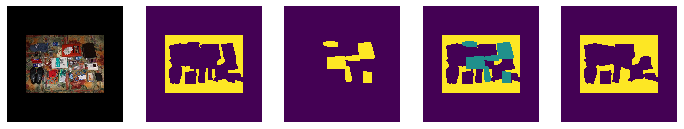

In [407]:
idx = 7
idx = idx - 1
if False:
    show([image, inmodal[idx], amodal_pred[idx]])
else:
    inmodal_show = cv2.resize(
        utils.crop_padding(inmodal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    eraser_show = eraser_patches[idx]
    comb = combine(inmodal_show, eraser_show)
    show([utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)),
          inmodal_show,
          eraser_show,
          comb,
          utils.crop_padding(amodal_pred[idx], bboxes[idx], pad_value=(0,))])

In [158]:
inmodal_show.shape

(148, 148)

In [ ]:
idx=11
idx-=1
otheridx = 3
otheridx-=1
inst = cv2.resize(utils.crop_padding(
    inmodal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
eraser = cv2.resize(utils.crop_padding(
    inmodal[otheridx], bboxes[otheridx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
eraser_setter = EraserSetter(tester.args.data['eraser_setter'])
eraser = eraser_setter(inst, eraser)
cv2.imwrite('/home/xhzhan/Work/tmp/inst.png', inst.astype(np.uint8) * 255)
cv2.imwrite('/home/xhzhan/Work/tmp/eraser_origin.png', eraser.astype(np.uint8) * 255)
cv2.imwrite('/home/xhzhan/Work/tmp/eraser_show.png', eraser.astype(np.uint8) * 128)

show_inst1 = inst.copy().astype(np.float32)
show_inst1[eraser==1] = 0.5

show_inst2 = inst.copy().astype(np.float32)
eraser[inst == 1] = 0
show_inst2[eraser==1] = 0.5

cv2.imwrite('/home/xhzhan/Work/tmp/show_inst1.png', (show_inst1 * 255).astype(np.uint8))
cv2.imwrite('/home/xhzhan/Work/tmp/show_inst2.png', (show_inst2 * 255).astype(np.uint8))

In [ ]:
crop_img = cv2.resize(utils.crop_padding(
    image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_LINEAR)

color=(1,0.6,0)
plt.figure(figsize=(8,8))
# segm = maskUtils.encode(np.asfortranarray(inst))
# poly = coco_segm_to_poly(segm)
poly = mask_to_polygon(inst).reshape((-1, 2))
polygon = patches.Polygon(poly, fill=True, facecolor=color, edgecolor=color, linewidth=3, alpha=0.5)
ax = plt.gca()
plt.imshow(crop_img)
ax.add_patch(polygon)
plt.axis('off')
plt.show()